# Selection of the rank of kernel conditional moment constraints
The rank of the kernel conditional moment constraints is the most important parameter of a kernel conditional moment constraints (KCMC) estimator. This is because a too low rank would give us too pessimistic a worst-case lower bound, while we would get an overly optimistic bound if the chosen rank is too high. 

For this purpose, use the reformulation of the KCMC estimator as an M-estimator. Once we have a M-estimation problem

\begin{equation*}
\hat\theta = \arg\min_{\theta\in\Theta} \hat {\mathbb{E}}_n \ell_\theta(Z),
\end{equation*}

we can apply any methods for model selection in statistics and machine learning. Here, in this notebook, we consider the following two approaches for selecting the rank of KCMC:
- Generalized information criterion
- Cross-validation

In [1]:
import warnings

import matplotlib.pyplot as plt
import torch

import confounding_robust_inference as cri

# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
policy = cri.policies.LogisticPolicy(beta)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(500)

## True Lower bound
Let us first compare the true lower bound calculated by Monte Carlo simulation with the KCMC lower bound estimator. We can clearly observe that higher dimension $D$ (i.e. model complexity) results in more optimistic lower bound, possibly due to the overfitting. 

In [2]:
D_min = 1
D_max = 200
step = 3
dims = list(range(D_min, D_max, step))

In [3]:
# We can also compute the theoretical robust policy value by Monte Carlo sampling with the true data distribution:
true_lower_bound = data.evaluate_policy_lower_bound(policy, Gamma=1.5, n_mc=100000)

In [4]:
def KCMC(D):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # just to ignore warnings on asymptotics
        est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=D)
        est.fit(Y, T, X, p_t, policy)
        return est.predict()


kcmc_list = [KCMC(d) for d in dims]

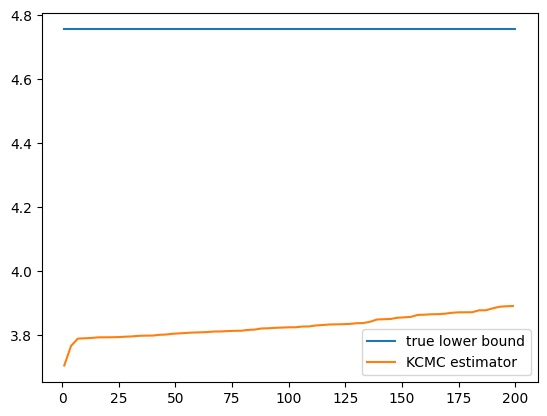

In [5]:
plt.plot([D_min, D_max], [true_lower_bound, true_lower_bound])
plt.plot(dims, kcmc_list)
plt.legend(["true lower bound", "KCMC estimator"])

## Generalized Information Criterion (GIC)

GIC is an estimator of the population risk of the M-estimator ${\mathbb{E}}\ell_{\hat\theta}(Z)$, (instead of empirical risk $\hat{\mathbb{E}}_n\ell_{\hat\theta}(Z)$). It is a generalized version of better-known AIC (Akaike's information criterion) for maximum likelihood estimation, and its derivation depends on the asymptotic analysis of the estimator.

In [6]:
def GIC(D):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # just to ignore warnings on asymptotics
        est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=D)
        est.fit(Y, T, X, p_t, policy)
        return est.predict_gic()


gic_list = [GIC(d) for d in dims]

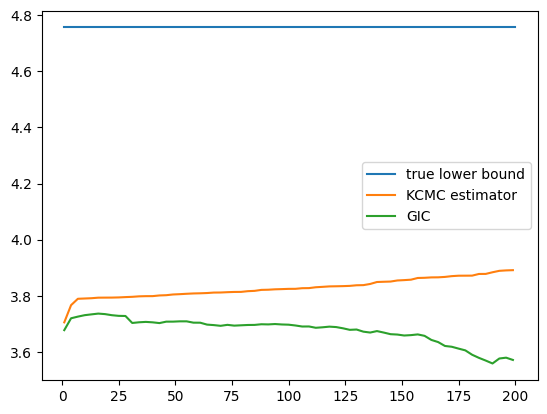

In [7]:
plt.plot([D_min, D_max], [true_lower_bound, true_lower_bound])
plt.plot(dims, kcmc_list)
plt.plot(dims, gic_list)
plt.legend(["true lower bound", "KCMC estimator", "GIC"])

## Cross-Validation

In [8]:
est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=10)
est.fit(Y, T, X, p_t, policy)
est.predict()

tensor(3.7902, dtype=torch.float64)

In [9]:
est.predict_dual(Y, T, X, p_t).mean()

tensor(3.7902, dtype=torch.float64)

In [10]:
k, K = 1, 10
is_train = torch.arange(Y.shape[0]) % K != k
is_valid = ~is_train
data_ = Y, T, X, p_t
est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=1)


data_train = map(lambda x: x[is_train], data_)
est.fit(*data_train, policy)

data_train = map(lambda x: x[is_train], data_)
est.predict_dual(*data_train).mean()

tensor(3.8013, dtype=torch.float64)

In [11]:
data_valid = map(lambda x: x[is_valid], data_)
est.predict_dual(*data_valid).mean()

tensor(2.8410, dtype=torch.float64)

In [12]:
est.predict_ci()

(tensor(3.7789, dtype=torch.float64), tensor(3.8237, dtype=torch.float64))

In [13]:
def CV(D, K=10):
    """K-fold cross validation"""
    scores = []
    data = Y, T, X, p_t
    for k in range(K):
        is_train = torch.arange(Y.shape[0]) % K != k
        is_valid = ~is_train
        data_train = map(lambda x: x[is_train], data)
        data_valid = map(lambda x: x[is_valid], data)
        est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=D)
        est.fit(*data_train, policy)
        score = est.predict_dual(*data_valid).mean()
        scores.append(score)
    return sum(scores) / len(scores)


cv_list = [CV(d) for d in dims]

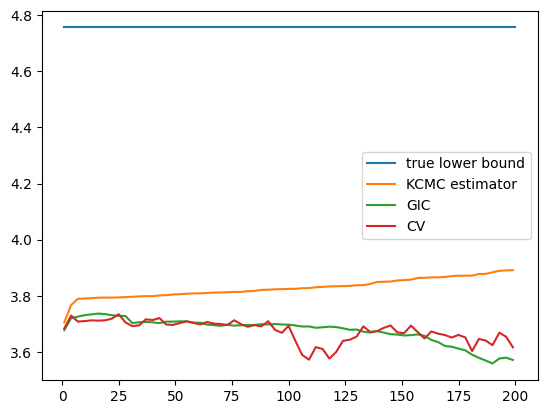

In [14]:
plt.plot([D_min, D_max], [true_lower_bound, true_lower_bound])
plt.plot(dims, kcmc_list)
plt.plot(dims, gic_list)
plt.plot(dims, cv_list)
plt.legend(["true lower bound", "KCMC estimator", "GIC", "CV"])